<h1 style="font-size: 42px; text-align: center;">HW5: Monte Carlo Tree Search and Naive Search</h1>

> **Full Name:** `Ali Najar`  
> **Student ID:** `401102701`  

<p align="center">
    <a href="https://colab.research.google.com/github/DeepRLCourse/Homework-5-Questions/blob/main/RL_HW5_MCTS.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
    </a>
    <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/DeepRLCourse/Homework-5-Questions/main/RL_HW5_MCTS.ipynb">
        <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle">
    </a>
</p>

---

## 📌 Overview

Welcome to **HW5**, where you will explore and implement search algorithms in reinforcement learning!  
In this assignment, you will:

✅ Implement **Monte Carlo Tree Search (MCTS)** and a **Naive Search Algorithm**.  
✅ Develop an agent that utilizes these techniques for decision-making.  
✅ Test and evaluate the performance of your agent.  

### 📂 Notebook Structure:
1️⃣ **Environment Definition**  
2️⃣ **Search Algorithms: Naive Search & MCTS**  
3️⃣ **Agent Implementation**  
4️⃣ **Training & Testing Loop**  

💡 *Each section includes explanations, docstrings, and `TODO` placeholders for missing implementations. Fill in the gaps and complete the assignment!*  

🚀 *Let's get started!*  


# Detailed Explanation of the Overall Algorithm

This notebook implements a MuZero-like approach to reinforcement learning, as described in the paper  
[“Mastering Atari, Go, Chess and Shogi by Planning with a Learned Model” (Schrittwieser et al., 2019)](https://arxiv.org/abs/1911.08265).  
Below is an overview of the key components and how they work together:

---

## 1. Representation, Dynamics, and Prediction Networks

MuZero (and algorithms inspired by it) relies on three core neural networks:

1. **Representation Network (`RepresentationNet`)**  
   - **Goal**: Convert raw observations (e.g., game frames, board states) into a latent (hidden) state.  
   - **Why It Matters**: By encoding high-dimensional inputs (like pixel images) into a more compact form, downstream modules can operate efficiently on this latent space rather than the raw data.

2. **Dynamics Network (`DynamicsNet`)**  
   - **Goal**: Given the current hidden state and an action, predict the **next hidden state** and an **immediate reward estimate**.  
   - **Why It Matters**: This is the “model” portion of MuZero. It simulates how the hidden state changes when an action is taken, letting the algorithm plan forward without needing a hand-crafted or perfect simulator.

3. **Prediction Network (`PredictionNet`)**  
   - **Goal**: From a hidden state, predict:
     1. **A policy distribution** (probabilities of selecting each possible action)
     2. **A value estimate** (scalar measure of how good or bad the state is)  
   - **Why It Matters**: This guides the search and learning, telling us which actions are promising (policy) and how favorable the current position might be (value).

---

## 2. Monte Carlo Tree Search (MCTS) and Naive Depth Search

1. **Monte Carlo Tree Search (`MCTS` Class)**  
   - **Core Idea**: Repeatedly simulate many “what if?” scenarios (rollouts) to gather statistics on which actions lead to higher value.  
   - **Key Methods**:  
     - `run(...)`: Manages the entire search process from the root hidden state.  
     - `_expand_node(...)`: Expands a leaf node by calling the dynamics and prediction networks.  
     - `_backpropagate(...)`: Propagates the newly obtained value estimates back up the search path.  
     - `_calc_ucb(...)`: Calculates an Upper Confidence Bound (UCB) score to balance exploration (trying new actions) and exploitation (using known good actions).  
     - `_compute_pi()`: Aggregates the visit counts of each child action at the root to form a final policy distribution.  

2. **Naive Depth Search (`naive_depth_search(...)`)**  
   - **Core Idea**: Look ahead a fixed depth in a brute-force manner, expanding all action sequences up to that depth.  
   - **Why It Matters**: Though less sophisticated than MCTS, it offers a simpler example of planning. It enumerates action branches, accumulates rewards and discounted values, and then picks the best sequence.

---

## 3. Buffer Replay

- **Purpose**: Store entire trajectories (episodes) of experience, then allow sampling of smaller segments (sub-trajectories) for training.  
- **How**:  
  1. **`add_trajectories(...)`**: Inserts full episodes into the buffer.  
  2. **`sample_sub_trajectory(...)`**: Retrieves a sub-trajectory of length `k` (for an n-step return) from the stored episodes.  
  3. **`sample_batch(...)`**: Returns a batch of sub-trajectories for training the neural networks.  

---

## 4. Agent

- **Role**: Central coordinator that uses the networks (Representation, Dynamics, Prediction) and search algorithms (MCTS or naive) to choose actions.  
- **Key Functions**:
  1. **`inference(...)`**: Given an observation, the agent converts it to a hidden state, then either:
     - Runs MCTS to derive a policy (if `search_type="mcts"`)
     - Performs a naive depth search (if `search_type="naive"`)
     - Or uses the direct policy from the `PredictionNet` (if no search is enabled)  
    The chosen action, along with the policy distribution and value estimate, is returned.
  2. **`initial_step(...)`**: Processes the initial raw observation into a hidden state and then obtains policy/value estimates.  
  3. **`rollout_step(...)`**: Given a hidden state plus actions, calls the `DynamicsNet` to get the next hidden state and reward, and the `PredictionNet` to predict policy/value at that new state.

---

## 5. Overall Training Procedure

1. **Collect Trajectories**:  
   - The agent interacts with the environment, using either MCTS or naive search to pick actions.  
   - The environment returns observations/rewards that form trajectories (episodes).

2. **Store in Replay**:  
   - These full trajectories are added to the `BufferReplay`.

3. **Sample Mini-Batches**:  
   - The training script samples sub-trajectories from the buffer (via `sample_sub_trajectory(...)` or `sample_batch(...)`).

4. **Unroll the Model**:  
   - For each sampled sub-trajectory, the code unrolls the networks (`RepresentationNet`, `DynamicsNet`, `PredictionNet`) for multiple steps (up to `k`) to compare the model’s predictions to the actual transitions.

5. **Compute Loss & Update**:  
   - The total loss typically includes terms for:
     - **Value error** (predicted vs. actual return)
     - **Policy error** (predicted policy vs. search-derived/improved policy)
     - **Reward error** (predicted vs. actual immediate reward)  
   - Backpropagation updates the parameters of all three networks end-to-end.

6. **Repeat**:  
   - Continue this cycle of data collection and network updates until convergence.

## Library Imports

In [1]:
!pip install numpy==1.23.5

In [2]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import math

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
dtype = torch.float

In [4]:
##############################################
# Environment Runner
##############################################
class EnvironmentRunner:
    """
    Manages interactions with an OpenAI Gym environment:
    - Resets the environment
    - Steps through it given an agent's actions
    - Logs returns and gathers trajectory data
    """

    def __init__(self, gym_env):
        self.gym_env = gym_env
        self.num_actions = self.gym_env.action_space.n

        self.observation = self.gym_env.reset()
        self.episodes_count = 0


    def run(self, agent, show_render=False):
            """
            Runs one full episode:
            1) Resets environment
            2) Steps until done
            3) Logs returns
            4) Returns the collected trajectory
            """
            obs_list = []
            actions_list = []
            rewards_list = []
            done_list = []
            policy_list = []
            values_list = []

            # initial reset
            self.observation = self.gym_env.reset()
            obs_list.append(torch.tensor(self.observation))

            finished = False
            while not finished:
                # Let agent infer the next action
                chosen_action, distribution, val_est = agent.inference(
                    torch.tensor(self.observation, dtype=dtype, device=device)
                )

                next_obs, reward, finished, info = self.gym_env.step(chosen_action)

                # Store
                obs_list.append(torch.tensor(next_obs))
                actions_list.append(chosen_action)
                policy_list.append(torch.tensor(distribution))
                values_list.append(val_est)
                rewards_list.append(torch.tensor(reward))
                done_list.append(finished)

                # Optional render
                if show_render:
                    self.gym_env.render()
                    time.sleep(0.024)

                self.observation = next_obs

            self.episodes_count += 1
            return self.build_trajectory(obs_list, actions_list, rewards_list, done_list, policy_list, values_list)

    @staticmethod
    def build_trajectory(obs, acts, rews, finished_flags, pols, vals):
        return {
            "obs": obs,
            "actions": acts,
            "rewards": rews,
            "dones": finished_flags,
            "pis": pols,
            "vs": vals,
            "length": len(obs)
        }

class LoggingEnvRunner(EnvironmentRunner):
    """
    Extends EnvironmentRunner to log episode returns.
    """
    def __init__(self, env):
        super().__init__(env)
        self.episode_returns = []

    def run(self, agent):
        trajectory = super().run(agent)  # normal run
        # Summation of the episode's rewards:
        ep_return = float(np.sum(trajectory["rewards"]))
        self.episode_returns.append(ep_return)
        return trajectory

In [5]:
##############################################
# A simple Gym Wrapper
##############################################
class GymWrapper(gym.Wrapper):
    """
    A wrapper that folds multiple historical observations
    into a single stacked observation.
    """

    def __init__(self, env, history_len):
        super().__init__(env)
        self.history_len = history_len
        self.obs_dim = env.observation_space.shape[0]
        self.num_actions = env.action_space.n

    def reset(self):
        self.episode_return = 0
        self.observations_rollout = []

        obs = self.env.reset()
        self.observations_rollout.append(obs)

        return self.aggregate()

    def aggregate(self):
        """
        Stacks the last N observations (with possible zero-padding).
        Returns them as a flattened array of shape (1, -1).
        """
        stacked = np.zeros((self.history_len, self.obs_dim))

        current_length = len(self.observations_rollout)
        if current_length == self.history_len:
            stacked = np.array(self.observations_rollout)
        else:
            stacked[self.history_len - current_length :] = np.array(
                self.observations_rollout
            )

        return stacked.flatten().reshape(1, -1)

    def step(self, action):
        next_obs, reward, done, info = self.env.step(action)
        self.update_history(next_obs)
        aggregated_obs = self.aggregate()

        self.episode_return += reward
        if done:
            info["return"] = self.episode_return

        return aggregated_obs, reward, done, info

    def update_history(self, new_obs):
        if len(self.observations_rollout) == self.history_len:
            # drop oldest
            self.observations_rollout = self.observations_rollout[1:]
        self.observations_rollout.append(new_obs)

# `BufferReplay` Class

This class manages a replay buffer for reinforcement learning, specifically storing entire trajectories (episodes). It supports two main operations:

1. **Storing Trajectories**:  
   - `add_trajectories(new_trajectories)`: Appends new trajectories to the buffer. If the capacity is exceeded, it overwrites old trajectories in a circular manner.

2. **Sampling Sub-Trajectories**:  
   - `sample_sub_trajectory(k, n, discount)`: Randomly selects a single trajectory from the buffer, chooses a random start index within that trajectory, and extracts a sub-trajectory of length `k` for training. It also computes an `n`-step return for each step in the sub-trajectory, taking into account the discount factor.  
   - `sample_batch(batch_size, k, n, discount)`: Repeats the above sub-trajectory sampling multiple times to form a training batch.

## Data Structure Returned by `sample_sub_trajectory`

`sample_sub_trajectory` returns a dictionary with the following keys:

- **"obs"**: The observation at the starting point of the sub-trajectory.  
  - Type/Shape: Typically a tensor (or array) representing the state.  
- **"pi"**: A list of policy distributions (one per timestep in the sub-trajectory).  
  - Type/Shape: Each entry is usually a tensor of shape `(num_actions,)`, giving the probability distribution over actions.  
- **"v"**: (If included in your design) a list of value estimates for each step in the sub-trajectory.  
  - Type/Shape: Each entry could be a tensor of shape `(1,)` or just a single scalar representing the value.  
- **"actions"**: A list of integers (or tensors) indicating which action was taken at each step.  
  - Type/Shape: Each entry typically an integer in the range `[0, num_actions-1]`.  
- **"rewards"**: A list of rewards obtained for each step in the sub-trajectory.  
  - Type/Shape: Each entry is typically a scalar tensor (or float).  
- **"return"**: A list of n-step returns corresponding to each timestep in the sub-trajectory.  
  - Type/Shape: Each entry is usually a scalar tensor (or float) representing the discounted sum of rewards plus a discounted bootstrap value.

Overall, this dictionary encapsulates all the necessary data (observation, actions, rewards, policy, value, returns) for training, allowing algorithms to perform n-step updates or other forms of training that depend on short sequences of experience.


In [6]:
##############################################
# Buffer Replay (Experience)
##############################################
class BufferReplay:
    """
    Stores entire episodes (trajectories), then allows sampling
    sub-portions for training (k-step unroll & n-step return).
    """

    def __init__(self, capacity, num_actions):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.num_actions = num_actions

    def add_trajectories(self, new_trajectories):
        """
        Inserts new trajectories (episodes) into the memory buffer.

        Detailed Functionality:
        -----------------------
        1. Iterates over each trajectory in `new_trajectories`.
        2. If the buffer is not yet at `capacity`, append the new trajectory.
        3. If at capacity, overwrite the oldest trajectory in a circular manner.
        4. Updates the internal `position` pointer accordingly.

        Parameters:
        -----------
        new_trajectories : list
            A list of trajectory dictionaries, each containing keys like:
            - "obs": list of observations
            - "actions": list of actions
            - "rewards": list of rewards
            - "pis": list of policy distributions
            - "vs": list of value estimates (if present)
            - "length": an integer specifying the number of timesteps

        """
        for traj in new_trajectories:
            if len(self.memory) < self.capacity:
                self.memory.append(traj)
            else:
                self.memory[self.position] = traj

            self.position = (self.position + 1) % self.capacity

    def sample_sub_trajectory(self, k, n, discount):
        """
        Randomly picks a single stored trajectory and a start index,
        returning k-step unroll data plus n-step returns.

        Detailed Functionality:
        -----------------------
        1. Selects a random trajectory from the stored buffer.
        2. Chooses a random start index within that trajectory.
        3. Unrolls for `k` steps to gather:
           - Observations
           - Actions
           - Rewards
           - Policy distributions
        4. Computes the n-step return for each of these k steps:
           - Sums the discounted rewards
           - May add a bootstrap value if within bounds of the trajectory
        5. Handles out-of-bounds cases where the unroll extends beyond
           the trajectory length, using padding or default values where necessary.

        Parameters:
        -----------
        k : int
            The number of timesteps to unroll the environment from the chosen start index.
        n : int
            The n-step horizon for return calculation.
        discount : float
            The discount factor used for return computation.

        Returns:
        --------
        dict
            A dictionary with keys:
            - "obs": The initial observation at the start index.
            - "pi": List of policy distributions for each step (length `k+1`).
            - "v": (Optional, if your code includes it) List of value estimates per step.
            - "actions": List of actions taken (length `k+1`, including potential padding).
            - "rewards": List of rewards for each step in the unroll (length `k`).
            - "return": A list of computed n-step returns (length `k+1`).
        """

        data = {
            "obs": None,
            "pi": [],
            "v": [],
            "actions": [],
            "rewards": [],
            "return": [],
        }

        # Choose a random trajectory
        mem_idx = np.random.choice(len(self.memory), 1)[0]
        chosen_length = self.memory[mem_idx]["length"]
        last_idx = chosen_length - 1

        # Random start
        start = np.random.choice(chosen_length, 1)[0]

        # We'll record the initial observation
        data["obs"] = self.memory[mem_idx]["obs"][start]

        # Collect data for each unroll step
        for step in range(start, start + k + 1):
            lookahead = step + n

            # If looking beyond trajectory end, v_n = 0
            if lookahead >= last_idx:
                future_value = torch.tensor([0.0], device=device, dtype=dtype)
            else:
                future_value = self.memory[mem_idx]["vs"][lookahead] * (discount**n)

            # sum of discounted rewards up to n or end
            total_val = future_value
            max_reward_idx = min(last_idx, lookahead)
            enumer_rewards = list(
                enumerate(self.memory[mem_idx]["rewards"][step:max_reward_idx])
            )
            for i, single_r in enumer_rewards:
                total_val += single_r * (discount**i)

            data["return"].append(total_val)

            # Not storing reward for the very initial step in the unroll
            if step != start:
                if 0 < step <= last_idx:
                    data["rewards"].append(self.memory[mem_idx]["rewards"][step - 1])
                else:
                    data["rewards"].append(torch.tensor([0.0], device=device))

            # Pi distribution
            if 0 <= step < last_idx:
                data["pi"].append(self.memory[mem_idx]["pis"][step])
            else:
                # In case we are beyond the real trajectory
                uniform_probs = np.ones(self.num_actions) / self.num_actions
                data["pi"].append(torch.tensor(uniform_probs, dtype=dtype))

        # Build the real set of actions from the actual trajectory
        max_valid_step = min(last_idx - 1, start + k - 1)
        num_steps_valid = max_valid_step - start
        data["actions"] = self.memory[mem_idx]["actions"][
            start : start + num_steps_valid + 1
        ]

        # Fill with random actions if we unroll beyond the stored trajectory
        fill_count = k - num_steps_valid + 1
        for _ in range(fill_count):
            rand_act = np.random.choice(self.num_actions, 1)[0]
            data["actions"].append(rand_act)

        return data

    def sample_batch(self, batch_size, k, n, discount=0.99):
        """
        Returns a batch (list) of sub trajectories. Each item
        in the batch has the keys: obs, pi, v, actions, rewards, return

        Parameters:
        -----------
        batch_size : int
            Number of sub-trajectories to sample.
        k : int
            Number of unroll steps in each sub-trajectory.
        n : int
            Horizon for n-step return.
        discount : float
            Discount factor.

        Returns:
        --------
        list
            A list of dictionaries, each containing sub-trajectory data
            (with the same keys as described in `sample_sub_trajectory`).
        """

        batch_data = []
        for _ in range(batch_size):
            sample = self.sample_sub_trajectory(k, n, discount)
            batch_data.append(sample)
        return batch_data

    def __len__(self):
        """
        Returns the current number of stored trajectories in memory.
        """
        return len(self.memory)


# Representation, Dynamics, and Prediction Models

These three neural network classes (`RepresentationNet`, `DynamicsNet`, `PredictionNet`) work together to model different aspects of an environment in a reinforcement learning (RL) setting, often inspired by algorithms like MuZero or similar approaches.

1. **`RepresentationNet`**  
   - **Goal**: Transform a raw observation (from the environment) into a **hidden state** vector.  
   - **Role in RL**: This hidden state often serves as a compact, learned representation of the environment’s information and is used by subsequent models (such as `DynamicsNet` and `PredictionNet`) to make predictions about future states, rewards, policies, and values.

2. **`DynamicsNet`**  
   - **Goal**: Predict the **next hidden state** and **immediate reward** from the **current hidden state** and an encoded action.  
   - **Role in RL**: This allows a learning algorithm to “imagine” how the environment transitions forward without directly querying the real environment, enabling planning and lookahead.

3. **`PredictionNet`**  
   - **Goal**: Given a hidden state, output a **policy** (probability distribution over possible actions) and a **value estimate** (scalar).  
   - **Role in RL**:  
     - The **policy** guides action selection, telling us which actions might be best at each timestep.  
     - The **value estimate** helps evaluate how good or bad a particular state is, assisting with learning.

## Form of the Desired Outputs
- **`RepresentationNet`**:  
  Outputs a **hidden state** tensor of shape `(batch_size, hidden_dim)`.
- **`DynamicsNet`**:  
  Outputs two tensors:  
  1. **Next hidden state** of shape `(batch_size, hidden_dim)`  
  2. **Reward estimate** of shape `(batch_size,)`
- **`PredictionNet`**:  
  Outputs two tensors:  
  1. **Policy** of shape `(batch_size, num_actions)`, representing a probability distribution over actions.  
  2. **Value** of shape `(batch_size,)`, representing a scalar estimate of the state value.


In [46]:
##############################################
# Representation, Dynamics, Prediction models
##############################################
class RepresentationNet(nn.Module):

    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_dim),
        )

    def forward(self, x):
        return self.net(x)


class DynamicsNet(nn.Module):

    def __init__(self, hidden_dim, action_space):
        super().__init__()


        self.hidden_dim = hidden_dim

        self.net = nn.Sequential(
            nn.Linear(hidden_dim + 1, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_dim+1)
        )

    def forward(self, x):
        x = self.net(x)
        next_hidden , reward = x[:,0:self.hidden_dim] , x[:,-1]
        return next_hidden, reward

class PredictionNet(nn.Module):

    def __init__(self, hidden_dim, num_actions):
        super().__init__()

        self.num_actions = num_actions

        self.shared_fc = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions + 1),
        )

    def forward(self, hidden_x):
        x = self.shared_fc(hidden_x)
        policy, value = x[:, 0:self.num_actions], x[:, -1]

        return F.softmax(policy,dim=1), value


# MCTS And Naive Depth-Based Search

In this section, we have several classes and functions that support Monte Carlo Tree Search (MCTS) and a naive depth-based search approach:

1. **`AdaptiveNormalizer`**  
   - Tracks the running minimum and maximum values of inputs (e.g., Q-values).  
   - Allows for on-the-fly normalization of these values, which can stabilize the search process.

2. **`TreeNode`**  
   - Represents a node in the MCTS search tree.  
   - Stores statistics such as visit counts, the sum of value estimates, child edges, and prior probabilities.  
   - The node can also store a hidden state representation and an estimated reward for transitioning from a parent node.

3. **`MCTS` Class**  
   - Controls the MCTS search process.  
   - Contains key methods like `run`, `_expand_node`, `_backpropagate`, `_calc_ucb`, and `_compute_pi` for performing MCTS simulations, updating node statistics, and calculating action visit distributions.  
   - Uses a dynamics model and prediction model to simulate the environment forward and estimate policies/values.

4. **`naive_depth_search` Function**  
   - Demonstrates a simpler (but inefficient) depth-based search.  
   - Expands all actions up to a certain depth, computes rewards and leaf values, then picks the action sequence with the highest total return.

## Form of the Desired Outputs

- **`AdaptiveNormalizer`**:  
  - Provides two primary methods: `update(val)` to update min/max stats and `normalize(val)` to scale values into a normalized range.

- **`TreeNode`**:  
  - Stores `edges` mapping each possible action to another `TreeNode`.  
  - Maintains `avg_value` (the mean of all values backpropagated through it), `visit_count`, and `total_value_sum`.  
  - It may store `state_rep` (the current hidden state representation) and `reward_est` (the immediate reward from the parent node to itself).

- **`MCTS`**:  
  1. **`run(sims_count, root_state)`**:  
     - Orchestrates the entire MCTS procedure for a given number of simulations (`sims_count`).  
     - Returns the **visit counts** over actions (used to derive a policy) and the **average value** of the root node.  
  2. **`_expand_node(parent_node, new_node, chosen_action)`**:  
     - Expands the leaf node by calling the environment (or model) with a chosen action, obtaining the next hidden state, policy, value, and reward.  
     - Creates children edges for all possible actions from the new state.  
     - Returns the new value estimate for further backpropagation.  
  3. **`_backpropagate(leaf_value)`**:  
     - Starts at the leaf node and moves backward through the search path, updating each node’s visit count and total value sum with the discounted reward.  
  4. **`_calc_ucb(parent, child)`**:  
     - Calculates the Upper Confidence Bound (UCB) score for a given child node.  
     - Uses the node’s prior probability, visit counts, and normalized value estimates to balance exploration and exploitation.  
     - Returns a scalar score that can be used to pick the best child action.  
  5. **`_compute_pi()`**:  
     - Aggregates the visit counts for each action at the root node, which can be used as an approximate policy distribution.

- **`naive_depth_search`**:  
  - Explores every possible action combination up to a specified depth (`search_depth`).  
  - Accumulates reward and discounted values, then selects the best action path found.

Below, the bodies of certain functions have been removed and replaced with detailed docstrings explaining the required logic, along with a `TODO: Your code` placeholder.


In [47]:
##############################################
# MCTS Classes
##############################################
class AdaptiveNormalizer:

    def __init__(self):
        self.max_val = float("-inf")
        self.min_val = float("inf")

    def update(self, val):
        val_cpu = val.cpu()
        self.max_val = max(self.max_val, val_cpu)
        self.min_val = min(self.min_val, val_cpu)

    def normalize(self, val):
        val_cpu = val.cpu()
        if self.max_val > self.min_val:
            return ((val_cpu - self.min_val) / (self.max_val - self.min_val)).to(device)
        return val_cpu


class TreeNode:

    def __init__(self, prior_prob):
        self.prior_prob = prior_prob
        self.state_rep = None
        self.reward_est = 0
        self.edges = {}  # action -> TreeNode

        self.total_value_sum = 0.0
        self.visit_count = 0

    def is_expanded(self):
        return len(self.edges) > 0

    def avg_value(self):
        if self.visit_count == 0:
            return 0.0
        return self.total_value_sum / self.visit_count


##############################################
# Some utility function
##############################################


def minmax_normalize_state(s):
    b_size = s.shape[0]
    s_min = torch.min(s, dim=1)[0].reshape(b_size, 1)
    s_max = torch.max(s, dim=1)[0].reshape(b_size, 1)
    return (s - s_min) / (s_max - s_min)


class MCTS:


    def __init__(
        self,
        num_actions,
        dynamics_model,
        predict_model,
        controlling_agent,
        gamma=0.99,
    ):
        self.num_actions = num_actions
        # Initialize the exploration constants
        self.c1 = 1.25
        self.c2 = 19652
        self.gamma = gamma

        self.root_dirichlet_alpha = 0.25
        self.root_exploration_fraction = 0.25

        self.dynamics_model = dynamics_model
        self.prediction_model = predict_model
        self.agent = controlling_agent
        self.value_tracker = None  # Assigned new for each search

    def run(self, sims_count, root_state):

        # Create the root
        init_policy, init_value = self.prediction_model(root_state)
        init_policy, init_val = init_policy.detach(), init_value.detach()
        self.root_node = self._initialize_root(root_state, init_policy)

        # track min/max for value normalization
        self.value_tracker = AdaptiveNormalizer()

        # Perform MCTS simulations
        for _ in range(sims_count):
            self.search_path = []
            self.search_path.append(self.root_node)
            self.action_path = []

            current_node = self.root_node
            # Traverse down the tree
            # A loop that goes down the tree until a leaf is reached
            while current_node.is_expanded():

                act_chosen, next_node = self._select_ucb_action(current_node)
                self.action_path.append(act_chosen)
                self.search_path.append(next_node)

                current_node = next_node


            leaf_parent = self.search_path[-2]  # The node from which we took act_chosen
            new_value = self._expand_node(
                leaf_parent,
                self.search_path[-1],
                self.action_path[-1],
            )

            # Backup
            self._backpropagate(new_value)

        # Return (visit distribution, root value)
        pi = self._compute_pi()
        root_val = self.root_node.avg_value()
        return pi, root_val

    def _expand_node(self, parent_node, new_node, chosen_action):
        next_s , policy_pred, value_pred, reward_pred = self.agent.rollout_step(parent_node.state_rep, [chosen_action])

        # detach the new values
        next_s_detached = next_s.detach()
        reward_detached = reward_pred.detach()
        policy_detached = policy_pred.detach()
        value_detached = value_pred.detach()
        # update the new node
        new_node.state_rep = next_s_detached
        new_node.reward_est = reward_detached

        # create children edges
        for act in range(self.num_actions):
            prior_prob = policy_detached[0, act]  # shape (1, num_actions)
            new_node.edges[act] = TreeNode(prior_prob)

        return value_detached  # Single scalar used for backprop

    def _backpropagate(self, leaf_value):

        for node in reversed(self.search_path):
            # 1) Update sum of values and visit count
            node.total_value_sum += leaf_value
            node.visit_count += 1

            # 2) Update the normalizer with (reward_est + gamma * node.avg_value)
            #    (So that UCB calc can use normalized Q-values)
            self.value_tracker.update(node.reward_est + self.gamma * node.avg_value())
            leaf_value = node.reward_est + self.gamma * leaf_value

    def _select_ucb_action(self, node):

        # Evaluate UCB for each child
        ucb_scores = []
        for act_id in range(self.num_actions):
            child = node.edges[act_id]
            ucb_val = self._calc_ucb(node, child)
            ucb_scores.append(ucb_val)

        best_act = np.argmax(ucb_scores)
        return best_act, node.edges[best_act]


    def _calc_ucb(self, parent, child):


        # Compute the exploration factor (pb_c) using c1, c2, parent.visit_count, etc.
        visits = parent.visit_count
        pb_c = np.log((visits + self.c2 + 1) / self.c2) + self.c1
        exploration_term = pb_c * np.sqrt(visits) / (1 + child.visit_count)
        # Weighted by prior
        exploration_score = exploration_term * child.prior_prob
        # 2) Value term = reward + gamma * avg_value
        # We'll normalize the raw Q-value using `value_tracker`
        norm_q = 0
        if child.visit_count > 0:
            raw_q = child.reward_est + self.gamma * child.avg_value()
            # Convert to a tensor to normalize, then convert back to float
            norm_q = self.value_tracker.normalize(torch.tensor(raw_q, device=parent.state_rep.device))

        # 3) Final UCB
        return exploration_score + norm_q

    def _compute_pi(self):

        visits = np.array(
            [self.root_node.edges[a].visit_count for a in range(self.num_actions)],
            dtype=np.float32
        )
        return visits

    def _add_root_noise(self, root):
        """
        Adds Dirichlet noise to the root node's child prior probabilities
        to encourage exploration.
        """
        noise = np.random.dirichlet([self.root_dirichlet_alpha] * self.num_actions)
        frac = self.root_exploration_fraction
        for act_id, n_val in enumerate(noise):
            old_prior = root.edges[act_id].prior_prob
            root.edges[act_id].prior_prob = old_prior * (1 - frac) + n_val * frac
        return root

    def _initialize_root(self, root_tensor, p_init):

        p_init = p_init.detach().cpu().numpy()
        node = TreeNode(0)
        node.state_rep = root_tensor
        node.reward_est = 0

        for i in range(self.num_actions):
            node.edges[i] = TreeNode(p_init[0, i])

        # Add exploration noise
        node = self._add_root_noise(node)
        return node

import itertools

def naive_depth_search(agent, hidden_s, act_count, gamma_val, search_depth=3):


    # Initialize any data structures for storing accumulated rewards/values
    possible_acts = np.arange(act_count)

    # Just get the root value
    _, root_v = agent.pred_net(hidden_s)
    root_value = root_v.detach()

    rewards = torch.tensor([0.0], device=device)

    best_return = -1e9
    best_seq = None

    state = hidden_s

    for i in range(search_depth):

        state = torch.repeat_interleave(state,act_count,dim=0)
        actions = np.repeat([possible_acts],(act_count ** i) , axis=0).flatten()
        state, _ , v, reward = agent.rollout_step(state , actions)
        state, v, reward = state.detach(), v.detach(), reward.detach()

        rewards = torch.repeat_interleave(rewards, act_count, dim=0)

        reward = reward * (gamma_val ** i)
        rewards = rewards + reward

    v = v.cpu().numpy()
    rewards = rewards.cpu().numpy()
    v = v * (gamma_val ** search_depth)
    v = v + rewards

    max_index = np.argmax(v)
    indexes_per_action = act_count ** (search_depth-1)
    best_action = int(max_index/indexes_per_action)

    return best_action, root_value


# `Agent` Class

The `Agent` class is a neural network module that coordinates between:
- A **representation network** (`rep_net`) to encode raw observations into a hidden state.
- A **dynamics network** (`dyn_net`) to predict the next hidden state and reward given a current hidden state and action.
- A **prediction network** (`pred_net`) to output a policy distribution and value estimate from a hidden state.

The agent can use different search strategies to pick actions:
1. **MCTS (Monte Carlo Tree Search)**  
   - When `search_type="mcts"`, the agent constructs an MCTS object to run simulations and pick an action from the resulting search tree.
2. **Naive Depth Search**  
   - When `search_type="naive"`, the agent expands possible actions up to a specified `search_depth`, and chooses the best outcome.
3. **Direct Prediction**  
   - Otherwise, the agent relies purely on the `pred_net`’s policy and value to pick actions without search.

Key Methods:
- **`forward(obs)`**: Overrides the PyTorch module’s forward method (not used directly in the search logic here).
- **`inference(obs_tensor)`**: Determines the action to take given an input observation. This may involve MCTS or naive search, or direct prediction, depending on the agent’s settings.
- **`initial_step(obs)`**: Produces the hidden state representation and an initial policy/value from a raw observation. Useful for MCTS when creating the root node.
- **`rollout_step(hidden_s, chosen_actions)`**: Given hidden states and chosen actions, predicts the next hidden states, immediate rewards, and the policy/value at those next states.

## Desired Outputs
- **`inference(obs_tensor)`**:
  - **action_int**: An integer action index chosen by the search or direct policy sampling.
  - **policy_distribution**: A NumPy array (or torch tensor) of shape `(num_actions,)`, representing the probability distribution over actions.
  - **estimated_value**: A scalar estimate (float or tensor) of the state’s value.

- **`initial_step(obs)`**:
  - **s**: The hidden state tensor generated by `rep_net(obs)`.
  - **pol**: The policy distribution (shape: `(1, num_actions)`) predicted by the `pred_net`.
  - **v**: The value estimate (shape: `(1,)` or `(1,1)`) from the `pred_net`.

- **`rollout_step(hidden_s, chosen_actions)`**:
  - **next_hidden**: The predicted next hidden state(s).
  - **p**: The predicted policy distribution(s).
  - **v**: The predicted value(s).
  - **predicted_reward**: The immediate reward estimate(s) from the dynamics network.


In [49]:
##############################################
# Agent
##############################################
class Agent(nn.Module):


    def __init__(
        self,
        sim_count,
        act_count,
        rep_net,
        dyn_net,
        pred_net,
        search_type="mcts",
        disc_factor=0.99,
        naive_len=3,
    ):
        super().__init__()
        self.rep_net = rep_net
        self.dyn_net = dyn_net
        self.pred_net = pred_net

        self.num_actions = act_count
        self.gamma = disc_factor
        self.search_type = search_type
        self.simulations = sim_count
        self.naive_search_depth = naive_len
        self.temperature = 1.0

        if self.search_type == "mcts":
            self.mcts = MCTS(
                act_count, dyn_net, pred_net, self, gamma=disc_factor
            )
        else:
            self.mcts = None

    def forward(self, obs):

        return obs

    def inference(self, obs_tensor):

        # convert observation to hidden
        hidden = self.rep_net(obs_tensor)

        if self.mcts:
            child_visits, root_val = self.mcts.run(self.simulations, hidden)
            # Convert to a numpy array for distribution
            visits_sum = np.sum(child_visits)
            action_probs = child_visits / visits_sum

            # Apply temperature
            adjusted_pi = action_probs ** (1.0 / self.temperature)
            adjusted_pi /= np.sum(action_probs ** (1.0 / self.temperature))

            # Sample or argmax
            picked_action = np.random.choice(
                self.num_actions, p=adjusted_pi
            )
            adjusted_pi = torch.tensor(adjusted_pi).float()
            return picked_action, adjusted_pi, root_val
        elif self.search_type == "naive":
            best_a, r_val = naive_depth_search(
                self, hidden, self.num_actions, self.gamma, self.naive_search_depth
            )
            result_pi = np.zeros(self.num_actions, dtype=np.float32)
            result_pi[best_a] = 1.0
            return best_a, result_pi, r_val
        else:
            with torch.no_grad():
                pol, val = self.pred_net(hidden)  # shapes: (1, num_actions), (1,)
            # Convert to numpy
            pol_np = pol[0].cpu().numpy()  # shape (num_actions,)
            # Temperature-based sampling
            if self.temperature != 1.0:
                pol_np = pol_np ** (1.0 / self.temperature)
            pol_np_sum = pol_np.sum()
            if pol_np_sum > 1e-8:
                pol_np /= pol_np_sum
            else:
                pol_np = np.ones(self.num_actions, dtype=np.float32) / self.num_actions

            chosen_act = np.random.choice(self.num_actions, p=pol_np)
            return chosen_act, pol_np, val

    def initial_step(self, obs):

        s = self.rep_net(obs)          # shape (1, hidden_dim) or similar
        pol, v = self.pred_net(s)      # pol: (1, num_actions), v: (1,) or (1,1)
        return s, pol, v


    def rollout_step(self, hidden_s, chosen_actions):

        device = hidden_s.device
        batch_sz = hidden_s.shape[0]

        # 1) Encode actions in [0,1] (simple approach)
        # e.g. if actions are discrete, shape: (batch_sz,) -> one-hot
        chosen_actions = torch.tensor(chosen_actions, dtype=torch.float, device=device)
        act_enc =  chosen_actions.reshape(batch_sz,1)
        # Scale to [0,1] by dividing by num_actions
        act_enc /= self.num_actions

        # 2) Dynamics input: cat hidden_s + act_enc
        dyn_input = torch.cat([hidden_s, act_enc], dim=1)

        # 3) Pass through dynamics network => next hidden state, immediate reward
        next_hidden, predicted_reward = self.dyn_net(dyn_input)

        # 4) Pass next hidden through prediction net => policy + value
        p, v = self.pred_net(next_hidden)

        return next_hidden, p, v, predicted_reward


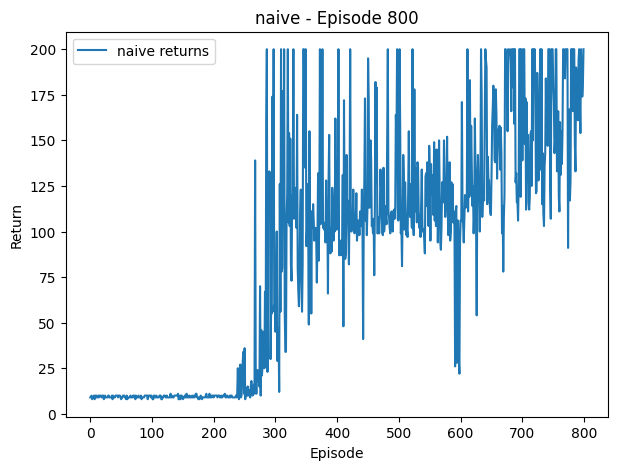

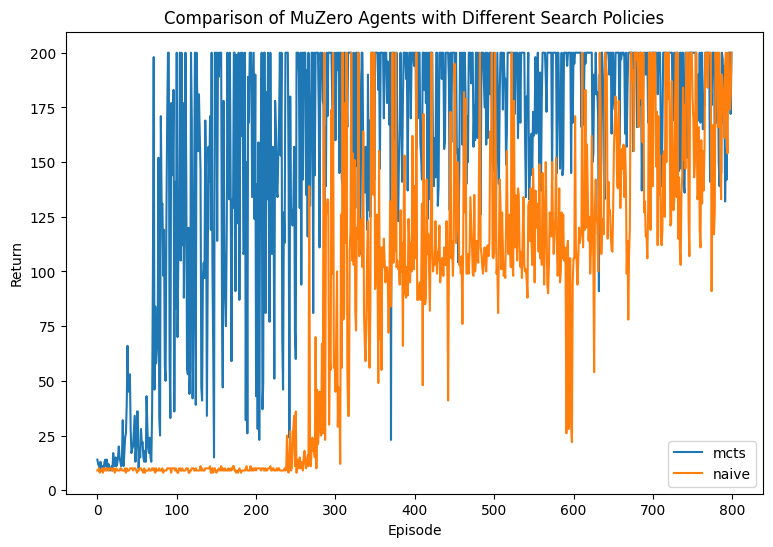

In [50]:
def train_with_search_policy(search_type='mcts'):

    # Your same hyper-params:
    history_length = 3
    num_hidden = 50
    num_simulations = 30
    replay_capacity = 1000
    batch_size = 32
    k = 5
    n = 10
    lr = 1e-3
    value_coef = 1
    reward_coef = 1

    # Environment
    raw_env = gym.make('CartPole-v0')
    num_obs_space = raw_env.observation_space.shape[0]
    num_actions = raw_env.action_space.n
    num_in = history_length * num_obs_space
    env = GymWrapper(raw_env, history_length)

    # Models
    # TODO: Create the models
    representation_model = RepresentationNet(num_in, num_hidden).to(device).to(dtype)
    dynamics_model = DynamicsNet(num_hidden, num_actions).to(device).to(dtype)
    prediction_model = PredictionNet(num_hidden, num_actions).to(device).to(dtype)


    agent = Agent(
        sim_count=num_simulations,
        act_count=num_actions,
        rep_net=representation_model,
        dyn_net=dynamics_model,
        pred_net=prediction_model,
        search_type=search_type,
        disc_factor=0.95,
        naive_len=3,
    )

    # Our "runner" is replaced with a LoggingEnvRunner:
    runner = LoggingEnvRunner(env)
    replay_buffer = BufferReplay(replay_capacity, num_actions)

    mse_loss = nn.MSELoss()
    cross_entropy_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        list(representation_model.parameters()) +\
        list(dynamics_model.parameters()) +\
        list(prediction_model.parameters()),
        lr=lr,
    )


    for episode in range(800):
        trajectory = runner.run(agent)
        replay_buffer.add_trajectories([trajectory])

        if len(replay_buffer) < 15:
            continue

        # Some temperature scheduling (unchanged)
        if episode < 250:
           agent.temperature = 1
        elif episode < 300:
            agent.temperature = 0.75
        elif episode < 400:
            agent.temperature = 0.65
        elif episode < 500:
            agent.temperature = 0.55
        elif episode < 600:
            agent.temperature = 0.3
        else:
            agent.temperature = 0.25


        # We do 16 mini-batch updates each episode:
        for i in range(16):
            optimizer.zero_grad()

            data = replay_buffer.sample_batch(batch_size, k, n, discount=0.99)


            representation_in = torch.stack(
                [torch.flatten(data[i]["obs"]) for i in range(batch_size)]
            ).to(device).to(dtype)

            actions = np.stack([np.array(data[i]["actions"], dtype=np.int64)
                                for i in range(batch_size)])
            rewards_target = torch.stack([torch.tensor(data[i]["rewards"])
                                          for i in range(batch_size)]).to(device).to(dtype)
            policy_target = torch.stack([torch.stack(data[i]["pi"])
                                         for i in range(batch_size)]).to(device).to(dtype)
            value_target = torch.stack([torch.tensor(data[i]["return"])
                                        for i in range(batch_size)]).to(device).to(dtype)

            loss = torch.tensor(0).to(device).to(dtype)

            # Initial step
            state, p, v = agent.initial_step(representation_in)

            policy_loss = mse_loss(p , policy_target[:,0].detach())
            value_loss = mse_loss(v, value_target[:, 0].detach())

            loss += (policy_loss + value_coef * value_loss) / 2.0

            # k unroll steps
            for step in range(1, k+1):
                step_action = actions[:, step - 1]

                next_s, p_next, v_next, rewards = agent.rollout_step(state, step_action)


                # policy_target[:, step, :] => shape (batch_size, num_actions)
                pol_loss = mse_loss(p_next , policy_target[:,step].detach())
                val_loss = mse_loss(v_next, value_target[:, step].detach())
                rew_loss = mse_loss(rewards, rewards_target[:, step - 1].detach())

                loss += (pol_loss + value_coef * val_loss + reward_coef * rew_loss) / k

                # update state
                state = next_s


            loss.backward()
            optimizer.step()

        if (episode + 1) % 5 == 0:
            clear_output(True)
            plt.figure(figsize=(7,5))
            plt.plot(runner.episode_returns, label=f'{search_type} returns')
            plt.title(f'{search_type} - Episode {episode+1}')
            plt.xlabel('Episode')
            plt.ylabel('Return')
            plt.legend()
            plt.show()

    return runner.episode_returns


all_results = {}
search_types = ['mcts','naive']

for s_type in search_types:
    returns = train_with_search_policy(s_type)
    all_results[s_type] = returns

plt.figure(figsize=(9,6))
for s_type in search_types:
    plt.plot(all_results[s_type], label=s_type)
plt.title("Comparison of MuZero Agents with Different Search Policies")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()
